In [1]:
import matplotlib.pyplot as plt
import PIL.Image as Image
import numpy as np
from random import randint


In [2]:
image_path = "../data/new_lego_colmap/images/r"
image_paths = []
for i in range (100):
    image_paths.append(image_path +"_"+ str(i) + ".png")

In [3]:
file_images_txt = open("../data/new_lego_colmap/sparse/0/images.txt", 'r')


In [4]:
class K_means :
    def __init__(self, k, max_iters=400):
        self.k = k
        self.max_iters = max_iters
        self.cluster = []
        self.i = 0
        self.resample = 32
        self.data = []
        self.data_paths = []
        
        
    def euclidean_distance(self, a, b):
        distance = 0
        for i in range(len(a)):
            distance += (a[i]-b[i])**2
        return distance**0.5
    
    def chi2_distance(self,a, b):
        eps = 1e-10
        sum = 0
        for i in range(len(a)):
            sum += ((a[i]-b[i])**2)/(a[i]+b[i]+eps)
        return 0.5 * sum
                
    def read_image(self, im):
        try:
            img = Image.open(im)

            # Resize to consistent size
            img = img.resize((self.resample, self.resample))

            # Convert to grayscale and flatten
            arr = np.asarray(img.convert("L")).flatten().astype(np.float32)

            # Normalize to [0,1]
            arr /= 255.0

            return arr.tolist()

        except Exception as e:
            print(f"Error reading {im}: {e}")
            return None

    def generate_k_means(self):
        final_means = []
        for c in range(self.k):
            partial_mean = []
            for i in range(len(self.data[0])):
                s = 0
                t = 0
                for j in range(len(self.data)):
                    if self.cluster[j] == c:
                        s += self.data[j][i]
                        t += 1
                if t > 0:
                    partial_mean.append(s/t)
                else:
                    # avoid empty means → re-seed with random point
                    idx = np.random.randint(0, len(self.data))
                    partial_mean.append(self.data[idx][i])
            final_means.append(partial_mean)
        return final_means
    
    def assign_clusters(self, means):
        # update cluster assignment for every data point
        for i in range(len(self.data)):
            d_min = float('inf')
            idx = 0
            for c in range(self.k):
                d = self.chi2_distance(self.data[i], means[c])
                if d < d_min:
                    d_min = d
                    idx = c
            self.cluster[i] = idx

    def generate_clusters(self, means):
        clusters = [[] for _ in range(self.k)]
        for i in range(len(self.data)):
            clusters[self.cluster[i]].append(self.data_paths[i])
        return clusters
    
    def open_data_paths(self, paths):
        self.data_paths = []
        self.data = []
        for p in paths:
            im = self.read_image(p)
            if im is not None:
                self.data.append(im)
                self.data_paths.append(p)
        
        # initialize cluster assignments randomly
        self.cluster = np.random.randint(0, self.k, len(self.data)).tolist()

    def fit(self):
        for _ in range(self.max_iters):
            means = self.generate_k_means()
            self.assign_clusters(means)

        return self.generate_k_means(), self.generate_clusters(means)


In [5]:
kmean_images = K_means(k=12)
kmean_images.open_data_paths(image_paths)

_,clusters = kmean_images.fit()   # <-- THIS runs K-means properly



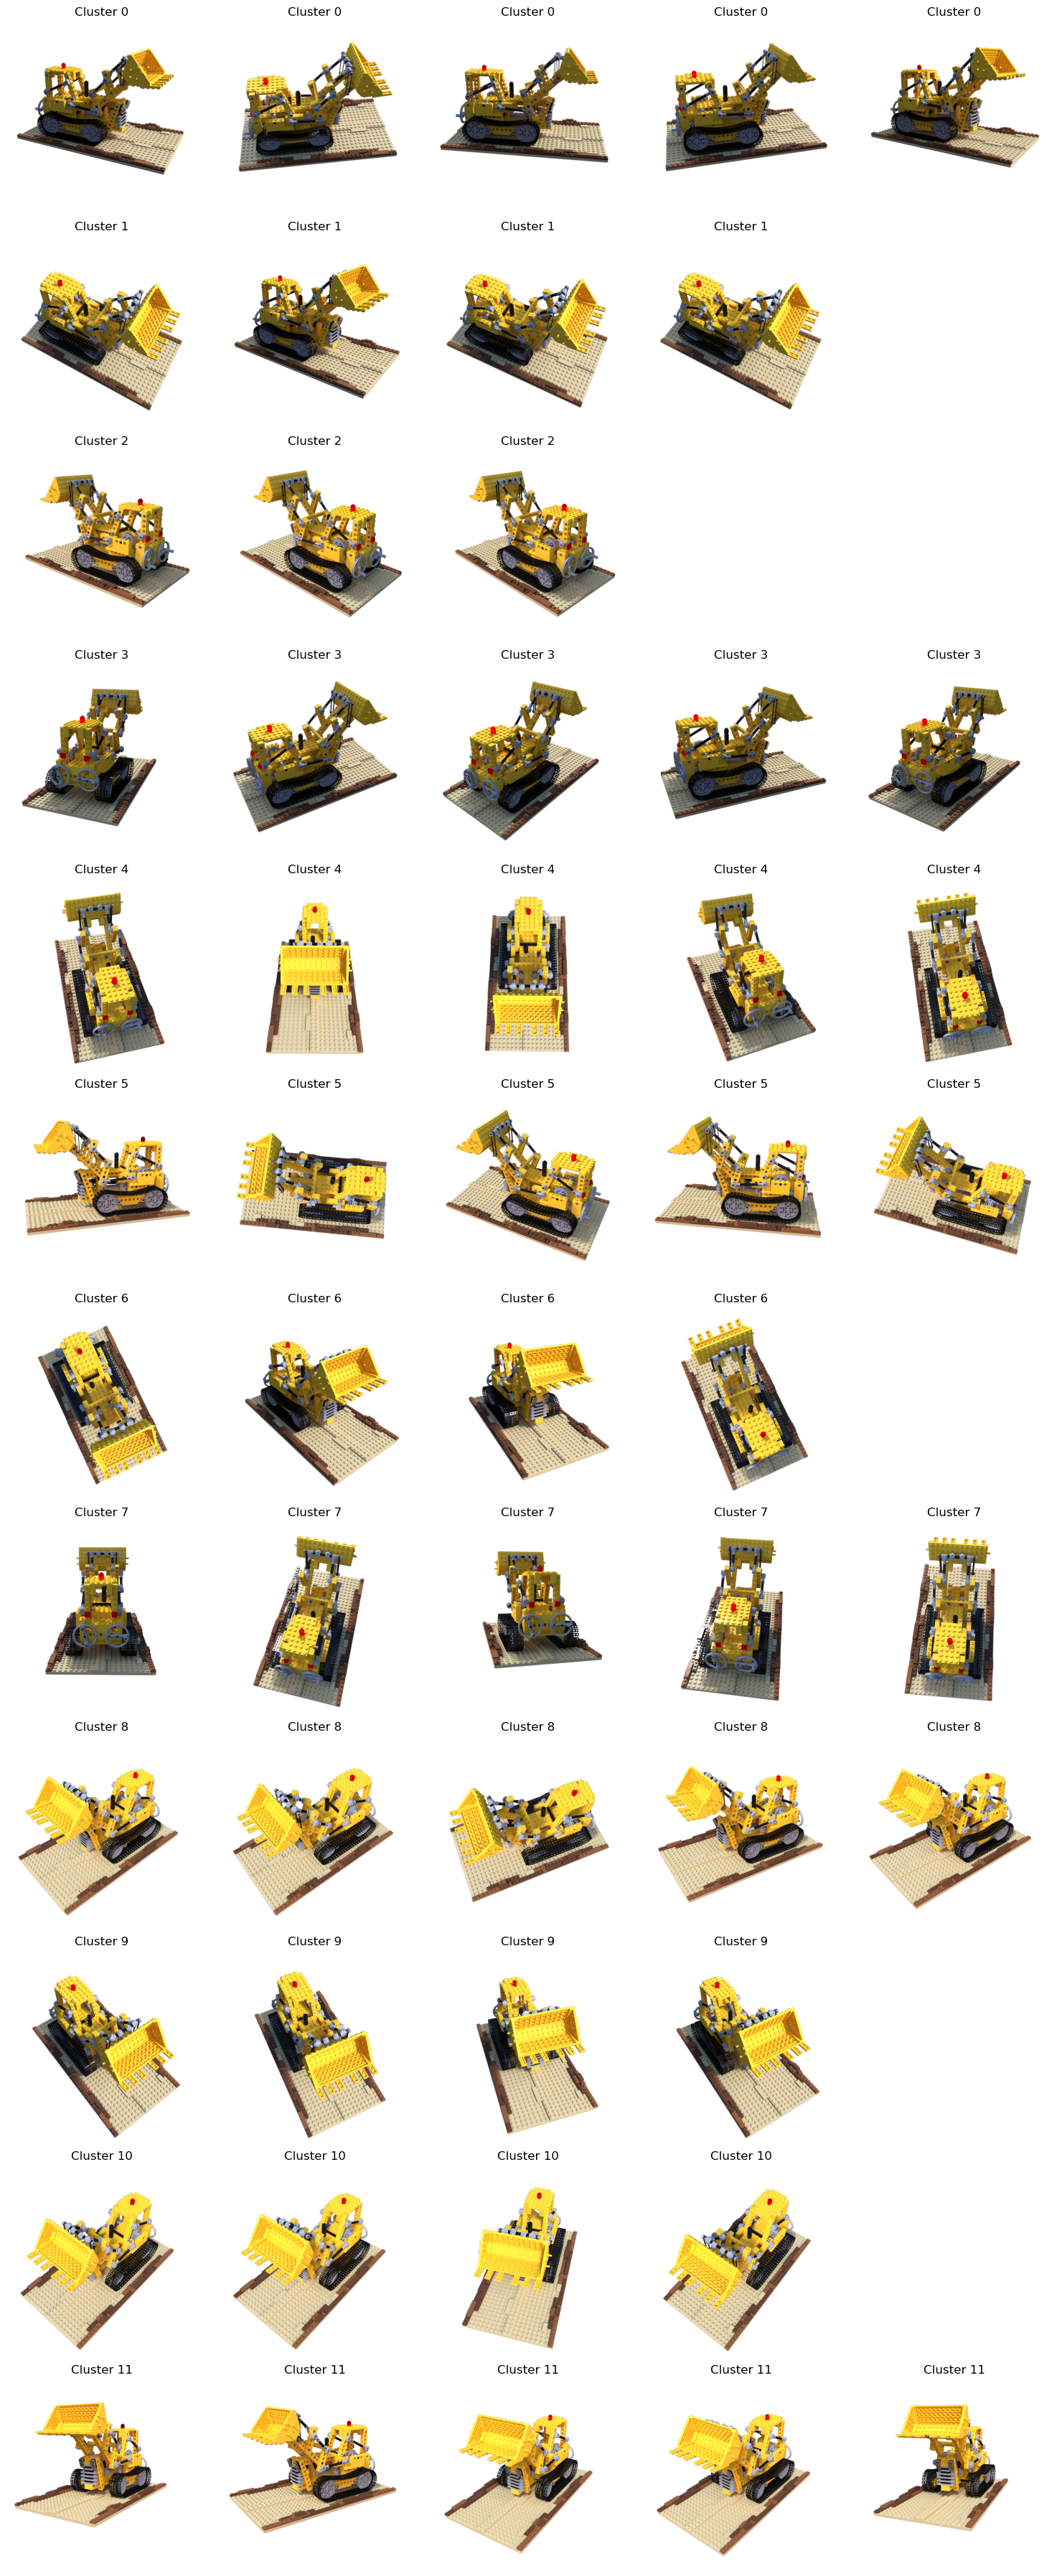

In [6]:
#open 3 images from each cluster in a grid and display them
fig, axs = plt.subplots(kmean_images.k, 5, figsize=(15, 3*kmean_images.k))
for i in range(kmean_images.k):
    for j in range(5):
        if j < len(clusters[i]):
            img = Image.open(clusters[i][j])
            axs[i, j].imshow(img)
            axs[i, j].axis('off')
            axs[i, j].set_title(f"Cluster {i}")
        else:
            axs[i, j].axis('off')
plt.tight_layout()
plt.show()

In [ ]:
#select 1 representative image from each cluster and save it
rep_images = []
for i in range(kmean_images.k):
    min_delta_to_mean = float('inf')
    representative_image = None
    for img_path in clusters[i]:
        img_data = kmean_images.read_image(img_path)
        delta = kmean_images.chi2_distance(img_data, kmean_images.generate_k_means()[i])
        if delta < min_delta_to_mean:
            min_delta_to_mean = delta
            representative_image = img_path
    if representative_image is not None:
        rep_images.append(representative_image)
        print(f"Representative image for cluster {i}: {representative_image}")

#open 3 images from each cluster in a grid and display them
fig, axs = plt.subplots(1, len(rep_images), figsize=(15, 3))
for i in range(len(rep_images)):
    img = Image.open(rep_images[i])
    axs[i].imshow(img)
    axs[i].axis('off')
    axs[i].set_title(f"Cluster {i} Rep")
plt.tight_layout()
plt.show()

Representative image for cluster 0: ../data/new_lego_colmap/images/r_83.png
Representative image for cluster 1: ../data/new_lego_colmap/images/r_93.png
Representative image for cluster 2: ../data/new_lego_colmap/images/r_15.png
Representative image for cluster 3: ../data/new_lego_colmap/images/r_96.png
Representative image for cluster 4: ../data/new_lego_colmap/images/r_79.png
Representative image for cluster 5: ../data/new_lego_colmap/images/r_77.png
Representative image for cluster 6: ../data/new_lego_colmap/images/r_7.png
Representative image for cluster 7: ../data/new_lego_colmap/images/r_39.png
Representative image for cluster 8: ../data/new_lego_colmap/images/r_99.png
Representative image for cluster 9: ../data/new_lego_colmap/images/r_92.png
Representative image for cluster 10: ../data/new_lego_colmap/images/r_36.png
Representative image for cluster 11: ../data/new_lego_colmap/images/r_63.png


In [45]:
def select_n_representative_images(clusters, n=1):
    rep_images = []
    for i in range(len(clusters)):
        cluster_images = clusters[i]
        selected_images = []
        if len(cluster_images) <= n:
            selected_images = cluster_images
        else:
            selected_indices = set()
            while len(selected_indices) < n:
                idx = randint(0, len(cluster_images) - 1)
                selected_indices.add(idx)
            selected_images = [cluster_images[idx] for idx in selected_indices]
        rep_images.append(selected_images)
    return rep_images

In [46]:
def write_line_to_file(file, line):
    file.write(line + "\n")

In [ ]:
def select_images_index(indices,file_selected_images, n_images):
    #images.txt is structured as follows:
    ## Image list with two lines of data per image:
#   IMAGE_ID, QW, QX, QY, QZ, TX, TY, TZ, CAMERA_ID, NAME
#   POINTS2D[] as (X, Y, POINT3D_ID)
# Number of images: 100, mean observations per image: 607.00999999999999
    write_details = False
    mean_obs_num = 0
    file_images_txt = open("../data/colmap-lego/sparse/0/images.txt", 'r')
    lines = file_images_txt.readlines()
    print(len(lines))
    lines_new = []
    k = 1
    for i in range(4, len(lines)):
        if (i%2) == 1:
            if write_details:
                lines_new.append(lines[i].strip())
                mean_obs_num += (len(lines[i].strip().split())//3)/n_images
        else :
            write_details = False
            parts = lines[i].strip().split()
            image_name = parts[9]
            print(image_name[2:-4])
            #remove r_ and .png to get the image id
            image_id = int(image_name[2:-4])
            if image_id in indices:
                write_details = True
                #replace the old index with the new one (first word of the line)
                l = lines[i].strip().split()
                l[0] = k
                k += 1
                lines_new.append(lines[i].strip())
    print(lines_new)
    
    write_line_to_file(file_selected_images,"# Image list with two lines of data per image:")
    write_line_to_file(file_selected_images,"# IMAGE_ID, QW, QX, QY, QZ, TX, TY, TZ, CAMERA_ID, NAME")
    write_line_to_file(file_selected_images,"# POINTS2D[] as (X, Y, POINT3D_ID)")

    write_line_to_file(file_selected_images,f"Number of images: {len(lines_new)//2}, mean observations per image: {mean_obs_num}")
    for line in lines_new:
        write_line_to_file(file_selected_images,line)

In [104]:
#rewrite images.txt with only the representative images
#create new folder in data
import os
new_colmap_path = "../data/colmap_lego_small/"
if not os.path.exists(new_colmap_path):
    os.makedirs(new_colmap_path)

In [105]:
#save representative images in the new folder
for img_path in rep_images:
    if img_path is None: continue
    img = Image.open(img_path)
    img_name = os.path.basename(img_path)
    img.save(os.path.join(new_colmap_path, img_name))

In [106]:
#create folder sparse in the new colmap folder
new_sparse_path = os.path.join(new_colmap_path, "sparse/0")
if not os.path.exists(new_sparse_path):
    os.makedirs(new_sparse_path)

#write new images.txt
file_selected_images = open(os.path.join(new_sparse_path, "images.txt"), 'w')
#select images indexes
selected_image_indices = set()
for img_path in rep_images:
    image_idx = img_path.split("_")[-1].split(".")[0]
    selected_image_indices.add(int(image_idx))
    print(f"Selected image index: {image_idx}")
   

select_images_index(selected_image_indices, file_selected_images, len(selected_image_indices))

Selected image index: 15
Selected image index: 66
Selected image index: 44
Selected image index: 39
Selected image index: 9
Selected image index: 73
Selected image index: 57
Selected image index: 80
Selected image index: 72
Selected image index: 33
204
0
1
10
11
12
13
14
15
16
17
18
19
2
20
21
22
23
24
25
26
27
28
29
3
30
31
32
33
34
35
36
37
38
39
4
40
41
42
43
44
45
46
47
48
49
5
50
51
52
53
54
55
56
57
58
59
6
60
61
62
63
64
65
66
67
68
69
7
70
71
72
73
74
75
76
77
78
79
8
80
81
82
83
84
85
86
87
88
89
9
90
91
92
93
94
95
96
97
98
99
['8 -0.47739212940469139 0.19953292875627401 0.56350795971599421 0.64400477052667526 0.40923778893394486 -2.4287040764058223 3.5820155367623006 1 r_15.png\n', '356.96517944335938 89.517005920410156 -1 320.9554443359375 98.462570190429688 -1 307.98577880859375 100.77783966064453 -1 335.82131958007812 104.88861083984375 -1 363.15667724609375 114.01704406738281 -1 203.14387512207031 115.98617553710938 -1 328.25973510742188 115.78076934814453 -1 328.2597351

In [110]:
path = "../data/colmap_lego_small/sparse/0/images.txt"

with open(path) as f:
    lines = f.readlines()

for i in range(2, len(lines), 2):
    line = lines[i].strip()
    if not line:
        print("Empty metadata line at", i+1)
        break

    parts = line.split()

    try:
        int(parts[0])      # IMAGE_ID
        int(parts[8])      # CAMERA_ID
    except Exception:
        print("❌ INVALID LINE", i+1)
        print(line)
        break
else:
    print("✅ No IMAGE_ID / CAMERA_ID errors found")

✅ No IMAGE_ID / CAMERA_ID errors found


## Creating a pipeline to select from the computed clusters

In [114]:
def select_n_representative_images(clusters, n=1, threshold=1.0):
    rep_images_per_cluster = []

    # Precompute cluster centers
    cluster_centers = kmean_images.generate_k_means()

    for i in range(kmean_images.k):
        cluster_reps = []

        # Handle empty cluster or None cluster center
        if not clusters[i] or cluster_centers[i] is None:
            print(f"Cluster {i} is empty or has no center.")
            rep_images_per_cluster.append(cluster_reps)
            continue

        cluster_center = cluster_centers[i]
        deltas = []

        for img_path in clusters[i]:
            img_data = kmean_images.read_image(img_path)
            if img_data is None:
                print(f"Warning: Could not read image {img_path}")
                continue

            delta = kmean_images.chi2_distance(img_data, cluster_center)
            if delta <= threshold:
                deltas.append((delta, img_path))

        deltas.sort(key=lambda x: x[0])
        selected = [img_path for _, img_path in deltas[:n]]
        cluster_reps.extend(selected)

        rep_images_per_cluster.append(cluster_reps)
        print(f"Representative images for cluster {i}: {cluster_reps}")

    return rep_images_per_cluster

select_n_representative_images(clusters, n=5) 

Error reading ../data/colmap-lego/images/r_4.png: [Errno 2] No such file or directory: '../data/colmap-lego/images/r_4.png'
Error reading ../data/colmap-lego/images/r_15.png: [Errno 2] No such file or directory: '../data/colmap-lego/images/r_15.png'
Error reading ../data/colmap-lego/images/r_22.png: [Errno 2] No such file or directory: '../data/colmap-lego/images/r_22.png'
Error reading ../data/colmap-lego/images/r_74.png: [Errno 2] No such file or directory: '../data/colmap-lego/images/r_74.png'
Representative images for cluster 0: []
Error reading ../data/colmap-lego/images/r_34.png: [Errno 2] No such file or directory: '../data/colmap-lego/images/r_34.png'
Error reading ../data/colmap-lego/images/r_38.png: [Errno 2] No such file or directory: '../data/colmap-lego/images/r_38.png'
Error reading ../data/colmap-lego/images/r_56.png: [Errno 2] No such file or directory: '../data/colmap-lego/images/r_56.png'
Error reading ../data/colmap-lego/images/r_66.png: [Errno 2] No such file or dir

[[], [], [], [], [], [], [], [], [], [], [], []]